# Cosine similarities
This notebook visualizes similarities between the concept vectors created for the manuscript *Supervised learning with word embeddings derived from PubMed captures latent knowledge about protein kinases and cancer*.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.spatial.distance import cosine
from collections import defaultdict
from sklearn.cluster import DBSCAN
import os
import sys
sys.path.insert(0, os.path.abspath('../..'))
from kcet import Wordvec2Cosine

## Obtaining the input data
The concept vectors are available from a zenodo repository: https://zenodo.org/record/5329035#.YTyvZXspBl9
Download the four files to a local directory and enter the path of this directory in the following input dialog
- embedding_SG_dim100_upto2010.npy
- embedding_SG_dim100_upto2020.npy
- words_SG_upto2010.txt
- words_SG_upto2020.txt

In [3]:
data_directory = input()

/home/peter/data/pubmed2vec


In [4]:
if not os.path.isdir(data_directory):
    raise FileNotFoundError("Could not find data directory")
embedding_file = os.path.join(data_directory, "embedding_SG_dim100_upto2020.npy")
words_file = os.path.join(data_directory, "words_SG_upto2020.txt")
w2c = Wordvec2Cosine(embeddings=embedding_file, words=words_file)
df = w2c.get_embeddings()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,2.892186,-4.601290,1.886768,3.363972,5.323241,2.037415,-4.547163,2.887746,0.078090,-6.857232,...,-2.348537,4.792399,3.246019,-3.045483,-4.771703,6.965374,-1.852824,0.788342,0.692204,8.816134
patient,3.030980,-4.654769,1.988458,3.286587,4.494266,4.335152,-3.879949,1.414752,0.948940,-4.057512,...,-1.655231,5.274243,5.277645,-1.659015,-4.128818,5.872729,-3.746760,1.387476,-0.132648,8.704845
meshd009369,3.125736,-5.037050,1.834232,3.044192,4.652200,3.345147,-2.471191,2.407151,0.459735,-5.215952,...,-1.343417,3.949077,5.909581,-3.753628,-5.255637,6.504014,-3.489765,1.265763,0.166798,9.207653
0,3.207781,-5.854365,2.169951,2.806666,3.704714,4.489932,-3.641227,2.849144,1.368201,-5.305769,...,-1.802601,4.349891,5.042999,-1.330444,-3.057492,6.769782,-4.191097,0.704711,0.271818,7.927824
study,3.093263,-3.081187,1.896351,3.586287,3.835986,3.025896,-3.602392,3.394049,0.388296,-4.770427,...,-1.487065,4.371748,4.851753,-3.033936,-4.145646,6.956510,-3.810457,0.859616,0.380740,8.665388


## Distribution of vector similarities
As described in the main manuscript, medically relevant words and phrases were replaced by concept ids using data from the [PubTator](https://www.ncbi.nlm.nih.gov/research/pubtator/) project. For instance, "Leukemia" corresponds to the MeSH id [meshd007938](https://meshb.nlm.nih.gov/record/ui?ui=D007938) and "Ovarian neoplasms" to [D010051](https://meshb.nlm.nih.gov/record/ui?ui=D010051). The following code retrieves the word vector for this concept and displays a histogram of similarities to other concept vectors.

In [5]:
target_word ='meshd007938' # Leukemia
n= df.shape[0]
all_cosine_similarities_leukemia = w2c.n_most_similar_words_df(target_word=target_word, n=n)

In [8]:
target_word ='meshd010051' # ovarian neoplasms
n= df.shape[0]
all_cosine_similarities_ovarian_neoplasms = w2c.n_most_similar_words_df(target_word=target_word, n=n)

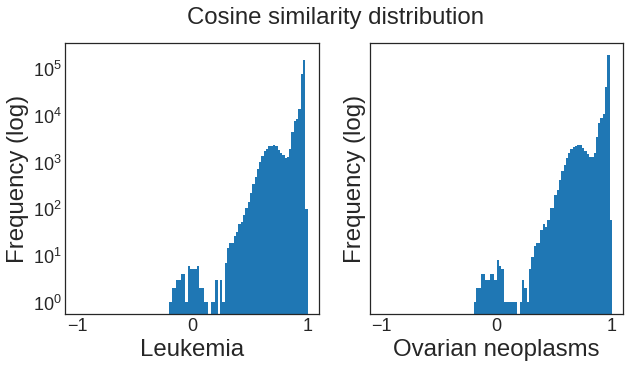

In [44]:
plt.style.use('seaborn-white')
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(10,5))
fig.suptitle('Cosine similarity distribution')
n, bins, patches = ax1.hist(all_cosine_similarities_leukemia["similarity"], bins=100, range=(-1, 1), histtype='bar')
n, bins, patches = ax2.hist(all_cosine_similarities_ovarian_neoplasms["similarity"], bins=100, range=(-1, 1), histtype='bar')

plt.yscale('log')

ax1.set(xlabel='Leukemia', ylabel='Frequency (log)')
ax2.set(xlabel='Ovarian neoplasms', ylabel='Frequency (log)')

plt.rc('axes',labelsize=24)
plt.rc('figure',titlesize=24)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 

## t-SNE plot
For demonstration purposes, here is a function that plots the n most and the n least similar words to any given vector. In this example, we use the vector for "Leukemia", which is MeSH id [D007938](https://meshb.nlm.nih.gov/record/ui?ui=D007938).

In [54]:
def plot_tsne_from_concept(target_concept: str, n_concepts: 50, w2c: Wordvec2Cosine) -> None:
    similarities = w2c.n_most_similar_words_df(target_word=target_concept, n=n_concepts)
    dissimilarities = w2c.n_least_similar_words_df(target_word=target_concept,n=n_concepts)
    pd.concat([similarities, similarities])
    tsne_model = TSNE(learning_rate=50)
    tsne_features = tsne_model.fit_transform(df, n_jobs=4)
    # We can adjust the eps to get more or less clusters
    get_clusters = DBSCAN(eps=5, min_samples=10).fit_predict(tsne_features)
    df["clusters"] = get_clusters
    set(get_clusters)
    # Here we are graphing  terms based on their word embeddings and visulized in a way that makes it
    # ideal to see clusters.
    df['tSNE_1'] = tsne_features[:,0]
    df['tSNE_2'] = tsne_features[:,1]
    sns.scatterplot(x="tSNE_1", y="tSNE_2", data=df, hue="clusters")
    plt.show()

In [55]:
leukemia = 'meshd007938'
plot_tsne_from_concept(target_concept = leukemia, n_concepts=50, w2c=w2c)

KeyboardInterrupt: 